# Time Series Forecasting of Traffic Patterns

This dataset includes traffic of four junctions of a city. The objective is to predict the traffic over the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you there are traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
sns.set(style="whitegrid")

## Exploratory Data Analysis

In [2]:
train_df = pd.read_csv(r"data/train_ML_IOT.csv")
train_df["DateTime"] = pd.to_datetime(train_df["DateTime"])
train_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


Each juntion is converted into a column using a pivot table. Any NaN is converted to a 0.

In [11]:
train_pivot = train_df.pivot(index="DateTime", columns="Junction", values="Vehicles")
train_pivot = train_pivot.fillna(0)
train_pivot

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


The formatted data set is visualized to track the trend of the traffic over time.

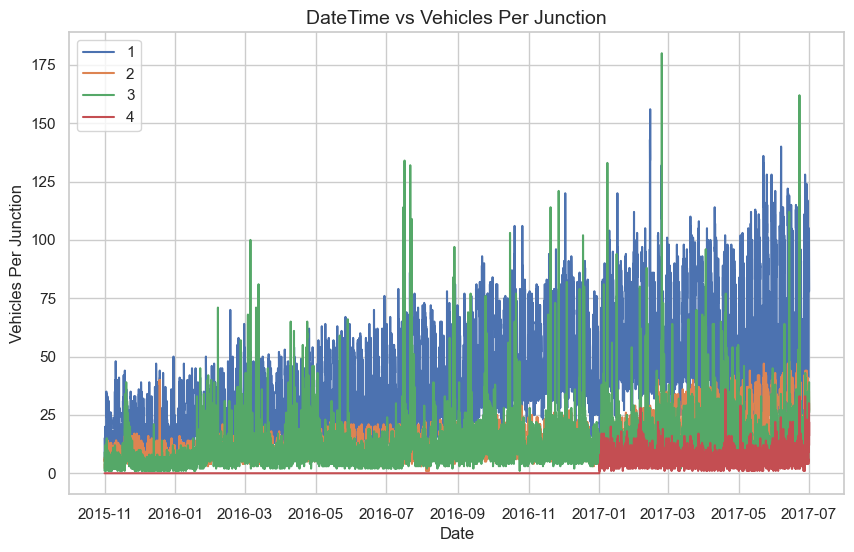

In [4]:
plt.figure(figsize=(10,6))

for column in train_pivot.columns:
    sns.lineplot(data=train_pivot[column], label=column)

plt.title("DateTime vs Vehicles Per Junction", fontsize=14)
plt.ylabel("Vehicles Per Junction", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.legend()
plt.show()

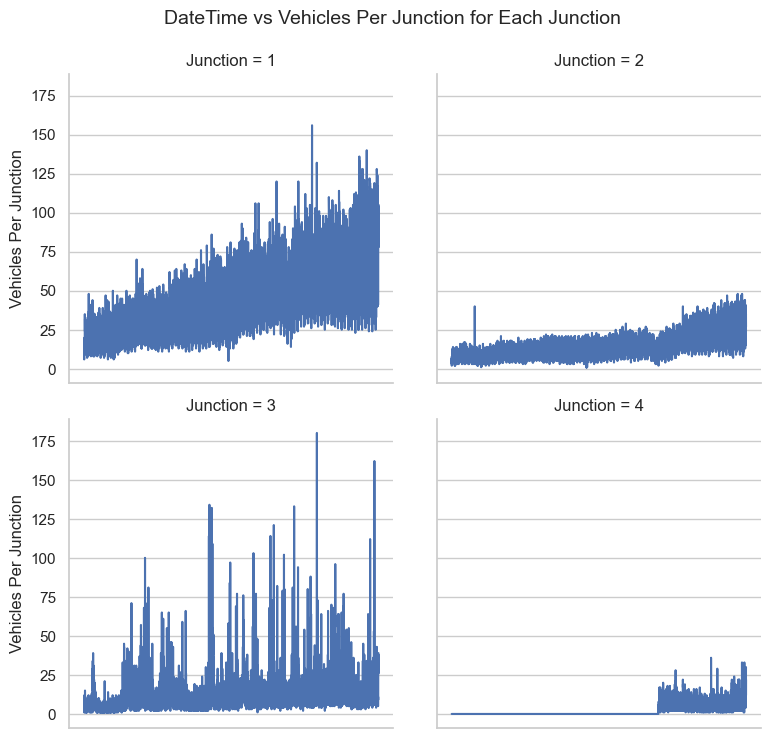

In [5]:
train_melted = train_pivot.reset_index().melt(id_vars='DateTime', var_name='Junction', value_name='Vehicles Per Junction')
train_melted = train_melted[train_melted["Junction"].isin((1, 2, 3, 4))]

g = sns.FacetGrid(train_melted, col='Junction', col_wrap=2, height=4)
g.map(sns.lineplot, 'DateTime', 'Vehicles Per Junction')
g.set(xticks=[], xlabel='')
g.fig.suptitle('DateTime vs Vehicles Per Junction for Each Junction', fontsize=14)
g.fig.subplots_adjust(top=0.9)

plt.show()


Plot of hourly data with yearly mean data.

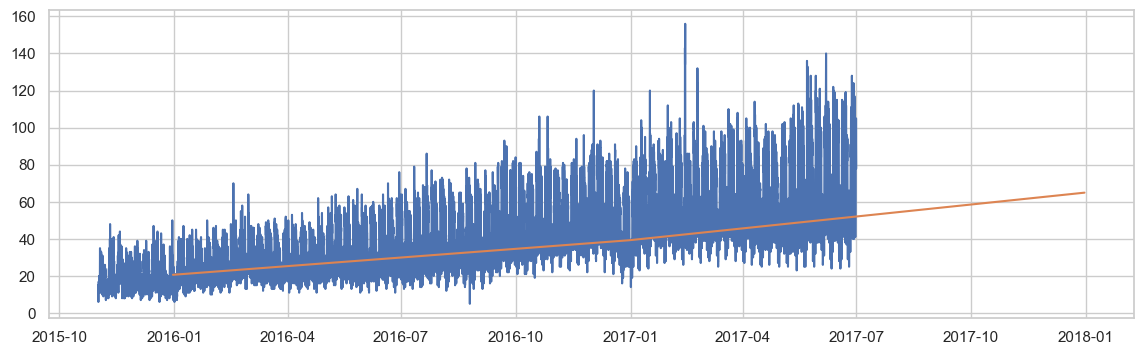

In [41]:
# resample to annual and plot each
annual_traffic_1 = train_pivot[1].resample("YE").mean()
plt.plot(train_pivot[1])
plt.plot(annual_traffic_1)
plt.grid(visible=True)

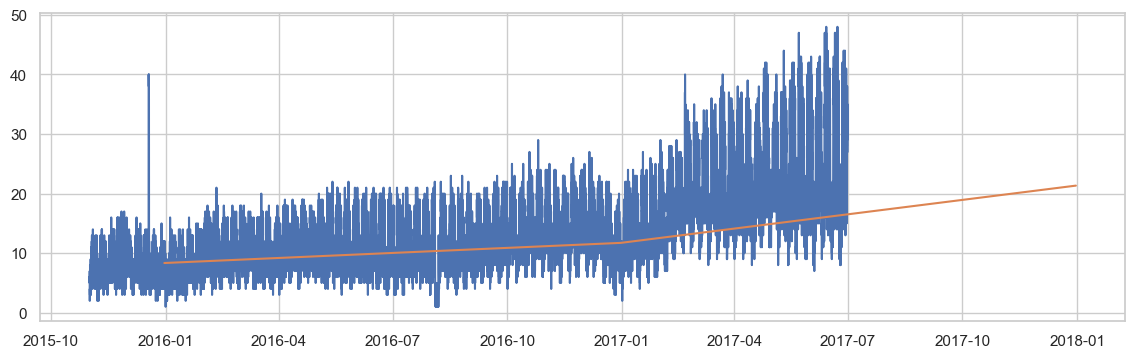

In [42]:
annual_traffic_2 = train_pivot[2].resample("YE").mean()
plt.plot(train_pivot[2])
plt.plot(annual_traffic_2)
plt.grid(visible=True)

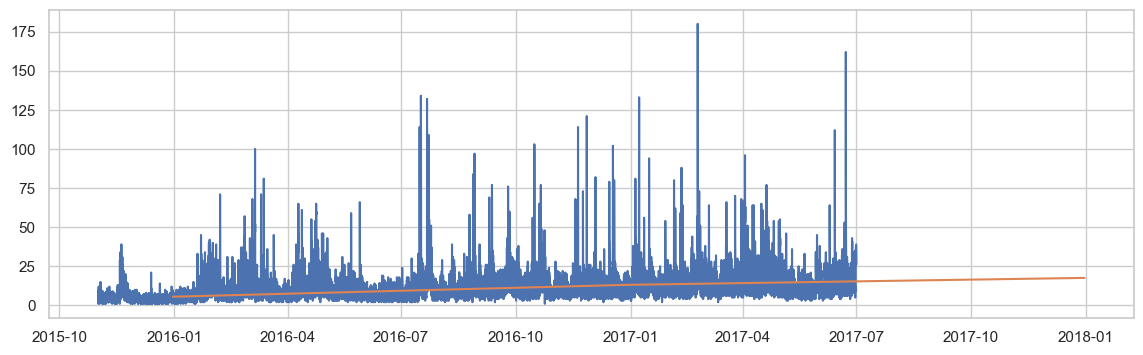

In [43]:
annual_traffic_3 = train_pivot[3].resample("YE").mean()
plt.plot(train_pivot[3])
plt.plot(annual_traffic_3)
plt.grid(visible=True)

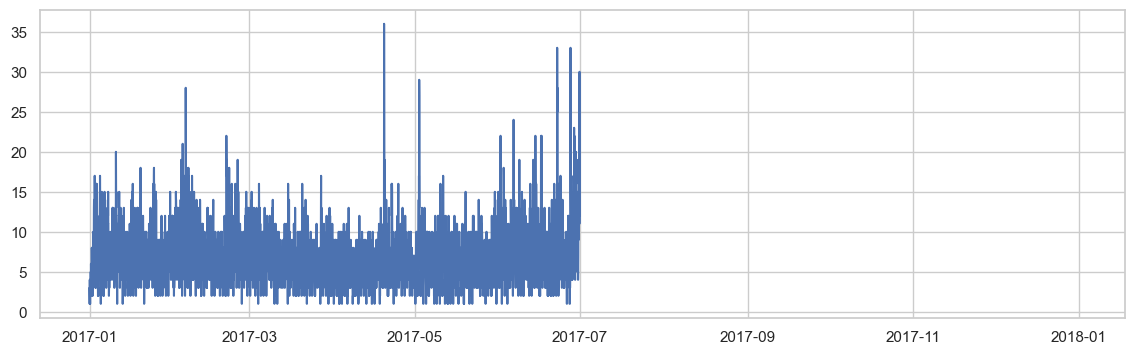

In [87]:
filtered = train_pivot[train_pivot[4].gt(0.0)]
annual_traffic_4 = filtered[4].resample("YE").mean()
plt.plot(filtered[4])
plt.plot(annual_traffic_4)
plt.grid(visible=True)

Violin plot to determine range and variance

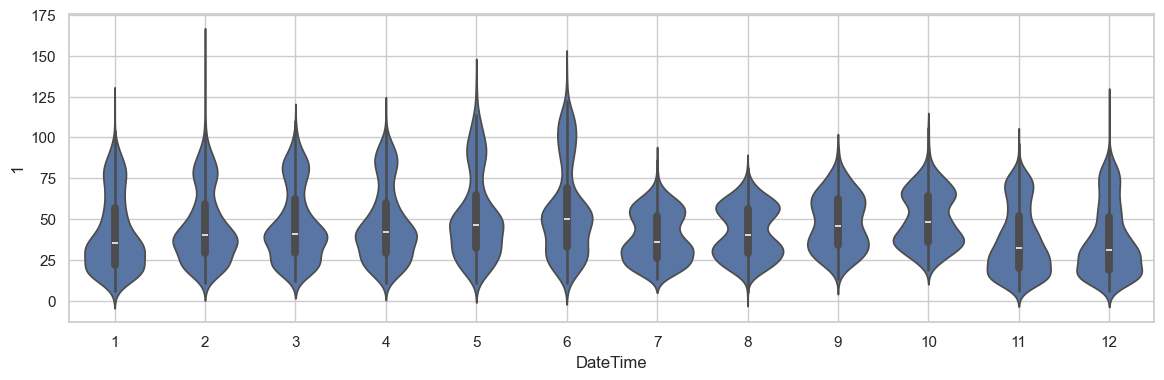

In [31]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[1])
plt.grid(visible=True)

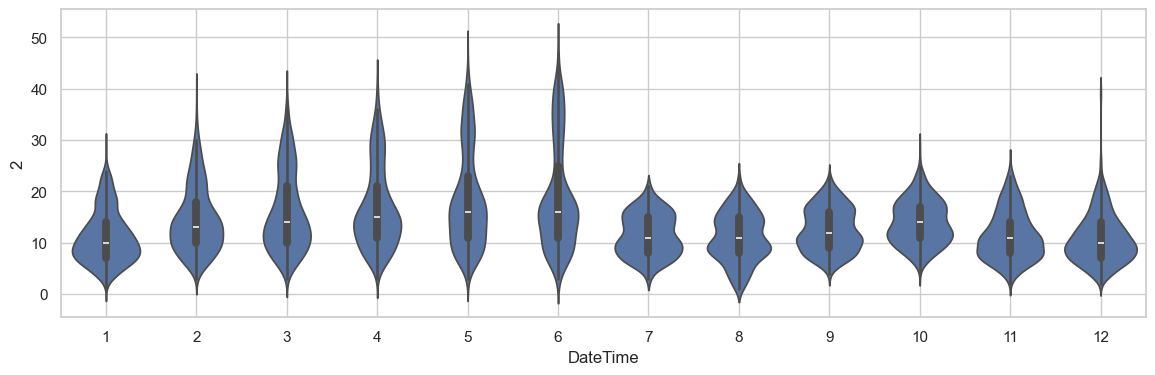

In [27]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[2])
plt.grid(visible=True)

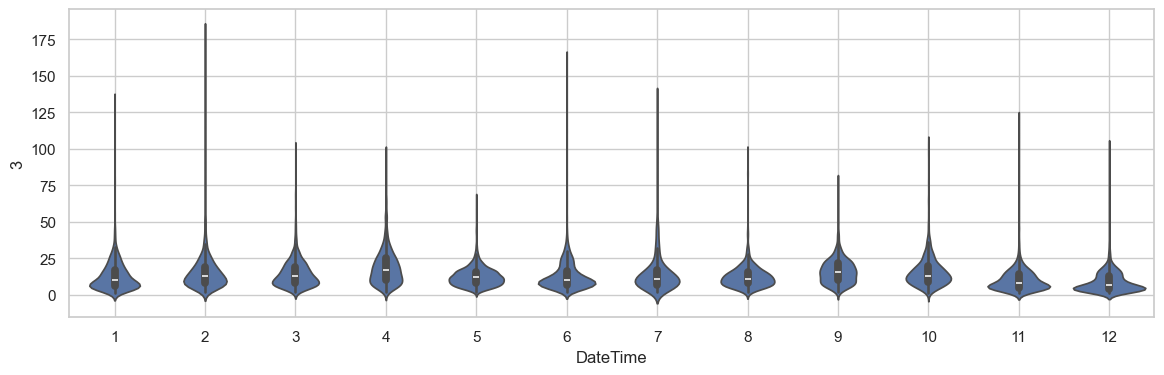

In [28]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[3])
plt.grid(visible=True)

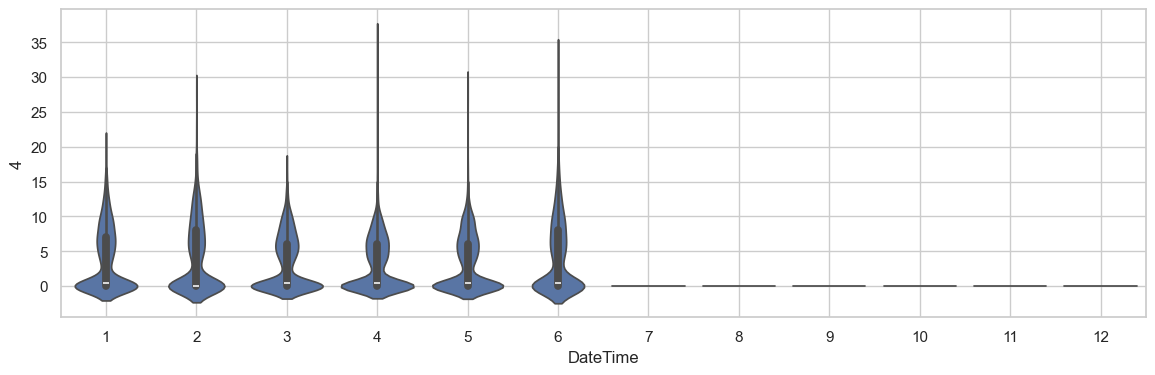

In [89]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[4])
plt.grid(visible=True)

## Dickey Fuller Test

The Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive (AR) time series model.

In [32]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts


def dftest(timeseries):
    dftest = ts.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.148078e+00
p-value                 3.193843e-10
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


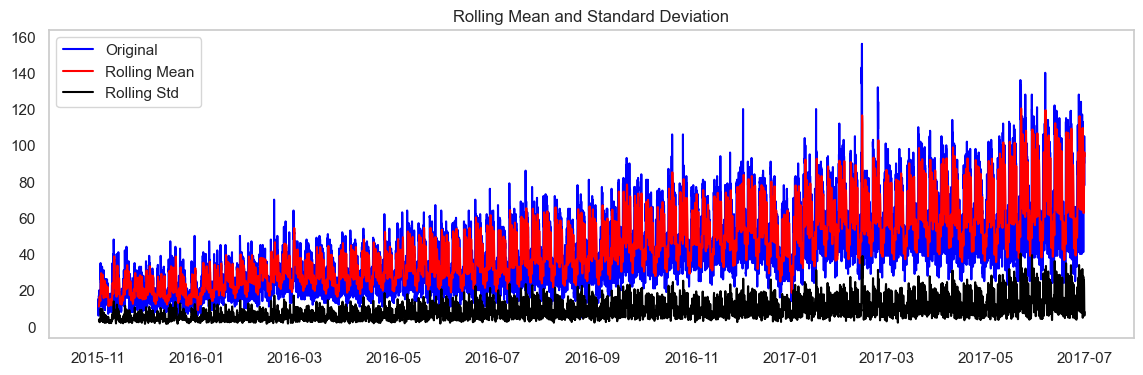

In [33]:
# run DFT on monthly
dftest(train_pivot[1])
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -8.041077e+00
p-value                 1.846368e-12
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


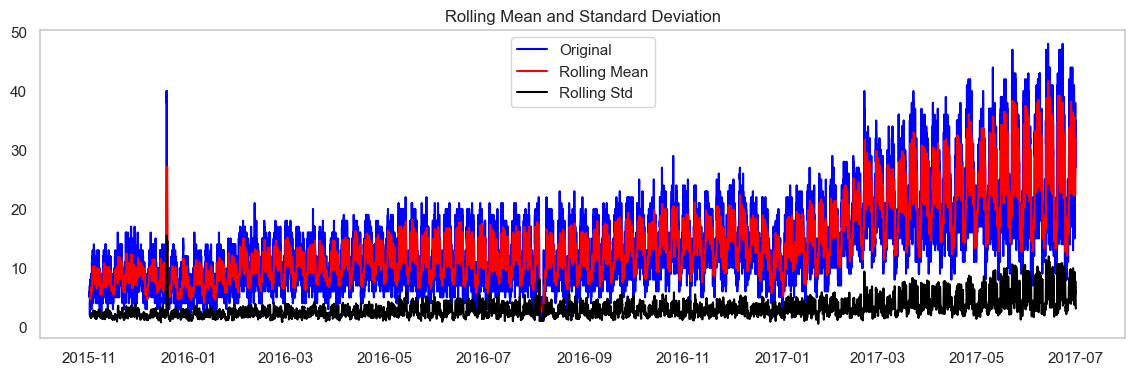

In [36]:
# run DFT on monthly
dftest(train_pivot[2])
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -8.236600e+00
p-value                 5.867296e-13
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


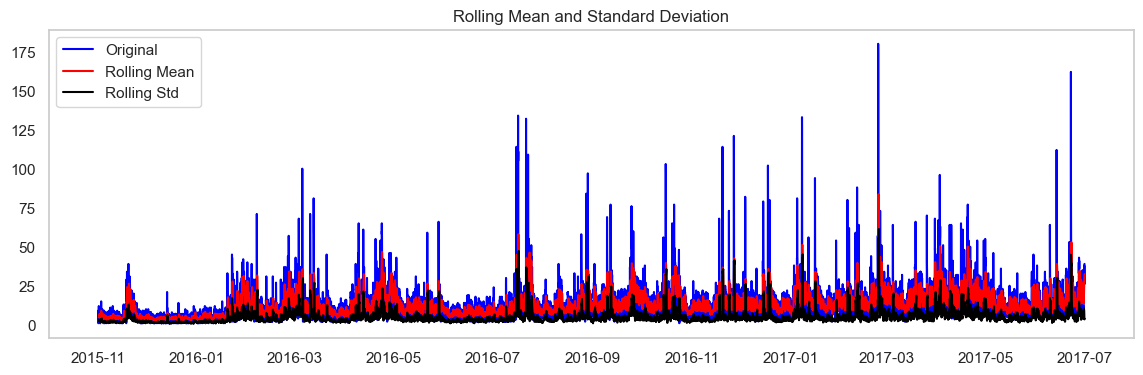

In [39]:
dftest(train_pivot[3])

Test Statistic         -6.726732e+00
p-value                 3.374875e-09
Lags Used               3.000000e+01
Observations Used       4.313000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862210e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


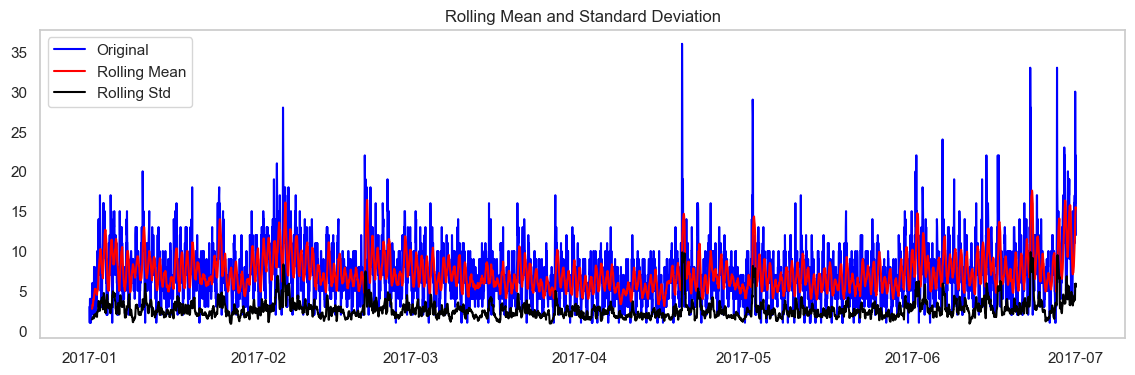

In [91]:
dftest(filtered[4])

The p-value allows us to *reject* a unit root (i.e. the data is stationary).

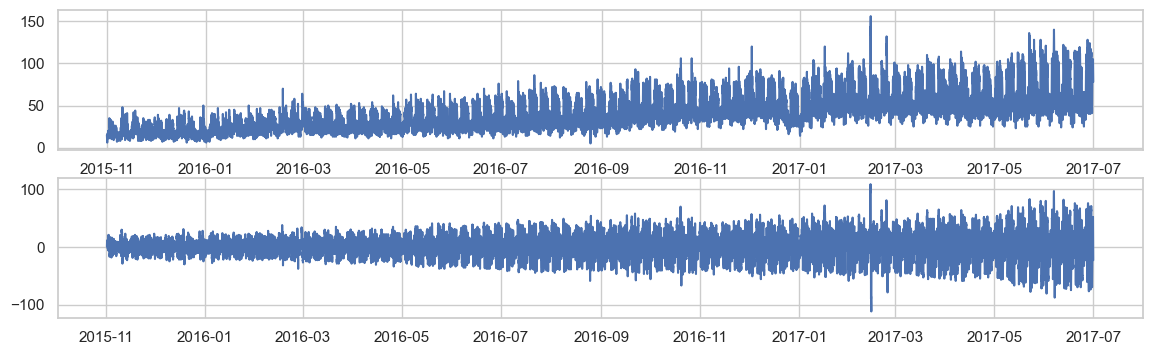

In [94]:
train_pivot["Junction 1 lag_12"] = train_pivot[1].shift(12)
train_pivot["Junction 1 seasonal_diff"] = train_pivot[1] - train_pivot["Junction 1 lag_12"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[1], label="original")
axes[1].plot(train_pivot["Junction 1 seasonal_diff"], label="seasonal diff")

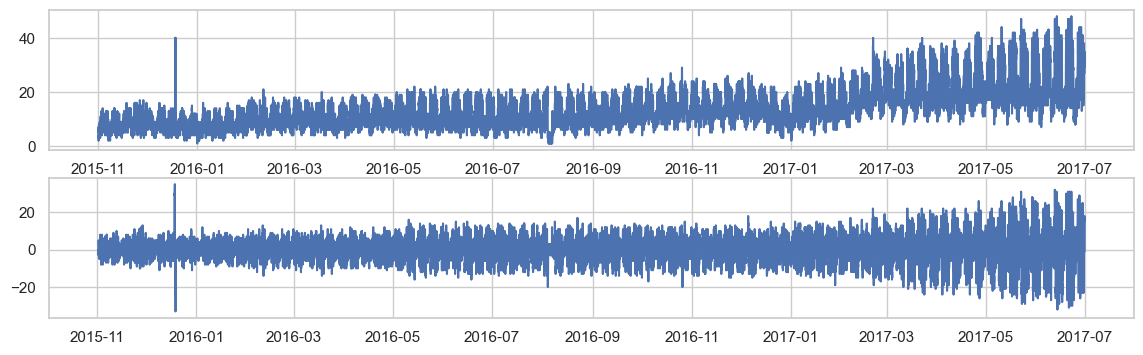

In [95]:
train_pivot["Junction 2 lag_12"] = train_pivot[2].shift(12)
train_pivot["Junction 2 seasonal_diff"] = train_pivot[2] - train_pivot["Junction 2 lag_12"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[2], label="original")
axes[1].plot(train_pivot["Junction 2 seasonal_diff"], label="seasonal diff")

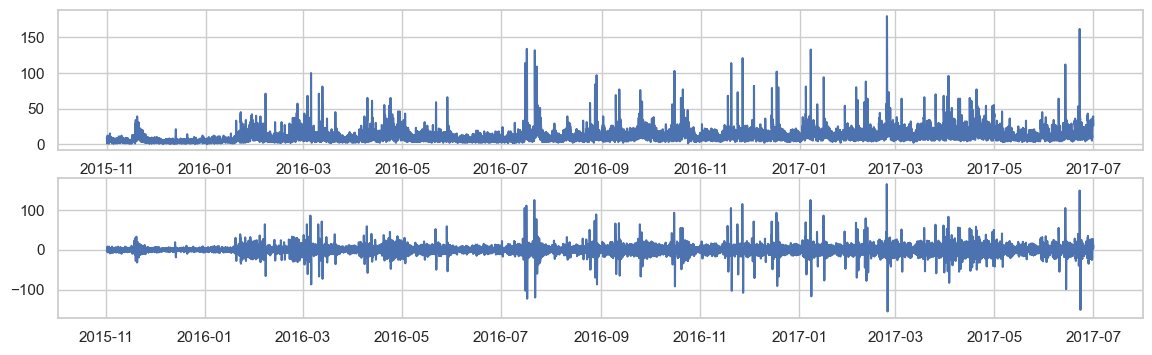

In [96]:
train_pivot["Junction 3 lag_12"] = train_pivot[3].shift(12)
train_pivot["Junction 3 seasonal_diff"] = train_pivot[3] - train_pivot["Junction 3 lag_12"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[3], label="original")
axes[1].plot(train_pivot["Junction 3 seasonal_diff"], label="seasonal diff")

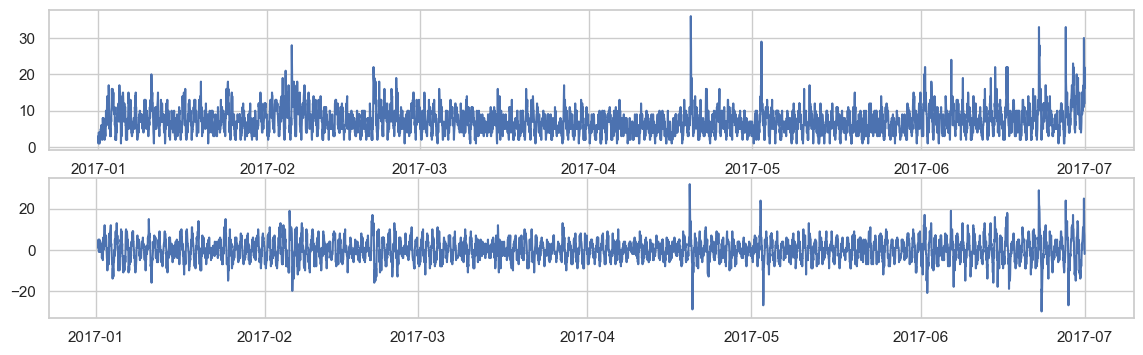

In [98]:
train_pivot["Junction 4 lag_12"] = filtered[4].shift(12)
train_pivot["Junction 4 seasonal_diff"] = filtered[4] - train_pivot["Junction 4 lag_12"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(filtered[4], label="original")
axes[1].plot(train_pivot["Junction 4 seasonal_diff"], label="seasonal diff")